# Modeling with Logistic Regression & Discriminant Analysis Methods

This notebooks contains model tuning for logistic regression, LDA, QDA, and Naive Bayes.  The product of this notebook will be models that can be used for prediction.

------

## Contents<a id='Contents'></a>
* [XXXX](#introduction--feature-descriptions)
* [Imports & Reading Data](#imports--readingpreparing-data)
---

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import sys
sys.path.append('../../../../DS_Mentorship_Projects/')

from csv import DictWriter

In [2]:
# Read csv into a pandas dataframe
df = pd.read_csv('../data/cleaned_heart_data.csv')
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ExerciseAngina_Y,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,Oldpeak_is_zero
0,40,140,289.0,0,172,0.0,0,1,0,1,0,0,1,0,0,1,1
1,49,160,180.0,0,156,1.0,1,0,0,0,1,0,1,0,1,0,0
2,37,130,283.0,0,98,0.0,0,1,0,1,0,0,0,1,0,1,1
3,48,138,214.0,0,108,1.5,1,0,1,0,0,0,1,0,1,0,0
4,54,150,195.0,0,122,0.0,0,1,0,0,1,0,1,0,0,1,1


In [3]:
# Split data into predictor features (X) and target feature (y)
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

In [4]:
# Split the data into a training and a test set (random state set for reproducability)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [5]:
#Impute missing cholesterol with medians for baseline models
imputer_for_baseline = SimpleImputer(strategy='median')
X_train_imputed =imputer_for_baseline.fit_transform(X_train)
X_test_imputed = imputer_for_baseline.fit_transform(X_test)

## Logistic Regression

Recall will be used rather than accuracy, precision, or other performance metrics since minimizing the rate of false negatives rather than false positives is more important with this data.

In [6]:
#Create baseline with missing cholesterol imputed with median
baseline_logreg = LogisticRegression(solver='liblinear')
baseline_logreg_cv_scores = cross_val_score(baseline_logreg, X_train_imputed, y_train, cv = 5, scoring = 'recall')
baseline_logreg_cv_score_mean = baseline_logreg_cv_scores.mean()
baseline_logreg_cv_score_std = baseline_logreg_cv_scores.std()

print(f'Baseline Logistic Regression CV Score(Recall): {baseline_logreg_cv_score_mean} +/- {baseline_logreg_cv_score_std}')

Baseline Logistic Regression CV Score(Recall): 0.8790772847487511 +/- 0.057328595463664145


In [7]:
# Get recall score for test data.  This will be the baseline 
baseline_logreg.fit(X_train_imputed, y_train)
y_predict_baseline = baseline_logreg.predict(X_test_imputed)
baseline_log_reg_test_recall = recall_score(y_test, y_predict_baseline)
print("Baseline Logistic Regression test recall:", baseline_log_reg_test_recall)

Baseline Logistic Regression test recall: 0.9148936170212766


In [8]:
logreg_pipe = make_pipeline(SimpleImputer(missing_values=np.nan),
                            StandardScaler(),
                            LogisticRegression(random_state=0, n_jobs=-1))

params = [
    {'simpleimputer__strategy': ['mean', 'median'],
     'standardscaler': [None, StandardScaler()],
     'logisticregression__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'logisticregression__penalty': ['l2', None],
     'logisticregression__fit_intercept': [True, False],
     'logisticregression__class_weight': [None, 'balanced']},
    {'simpleimputer__strategy': ['mean', 'median'],
     'standardscaler': [None, StandardScaler()],
     'logisticregression__solver': ['liblinear'],
     'logisticregression__penalty': ['l1', 'l2'],
     'logisticregression__fit_intercept': [True, False],
     'logisticregression__intercept_scaling': [1, 5, 10],
     'logisticregression__class_weight': [None, 'balanced']},
    {'simpleimputer__strategy': ['mean', 'median'],
     'standardscaler': [None, StandardScaler()],
     'logisticregression__solver': ['saga'],
     'logisticregression__penalty': ['l1', 'l2', None],
     'logisticregression__fit_intercept': [True, False],
     'logisticregression__class_weight': [None, 'balanced']},
    {'simpleimputer__strategy': ['mean', 'median'],
     'standardscaler': [None, StandardScaler()],
     'logisticregression__solver': ['saga'],
     'logisticregression__penalty': ['elasticnet'],
     'logisticregression__l1_ratio': [0.2, 0.4, 0.6, 0.8],
     'logisticregression__fit_intercept': [True, False],
     'logisticregression__class_weight': [None, 'balanced']}
    ]

grid_cv_logreg = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=5, 
                              scoring='recall', n_jobs=-1)
grid_cv_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=0))]),
             n_jobs=-1,
             param_grid=[{'logisticregression__class_weight': [None,
                                                               'balanced'],
                          'logisticregression__fit_intercept': [True, False],
                          'logisticregression__penalty': ['l2', None]...
                          'standardscaler': [None, StandardScaler()]},
                         {'logisticregression__class_weight': [None,
                                                               'balanced'],
                          'logisticregression__fit_intercept': [True, False],
                          'logisticregression__l1_ratio': [0.2, 0.4, 0.6, 0.8],
                          'logisticregression__penalty': ['elasticnet'],
                          'logisticregression__solver': ['saga'],
                          'simpleimputer__strategy': ['mean', 'median'],
                          'standardscaler': [None, StandardScaler()]}],
             scoring='recall')

In [9]:
grid_cv_results_logreg=pd.DataFrame(grid_cv_logreg.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_logreg[['param_simpleimputer__strategy', 'param_standardscaler',
                     'param_logisticregression__class_weight', 'param_logisticregression__fit_intercept', 'param_logisticregression__intercept_scaling',
                     'param_logisticregression__penalty', 
                     'param_logisticregression__l1_ratio', 
                     'param_logisticregression__solver', 
                     'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_simpleimputer__strategy,param_standardscaler,param_logisticregression__class_weight,param_logisticregression__fit_intercept,param_logisticregression__intercept_scaling,param_logisticregression__penalty,param_logisticregression__l1_ratio,param_logisticregression__solver,mean_test_score,std_test_score,rank_test_score
2,median,None,None,True,NaN,l2,NaN,lbfgs,0.886306,0.054023,1
17,mean,StandardScaler(),None,True,NaN,None,NaN,lbfgs,0.883955,0.060081,2
233,mean,StandardScaler(),None,True,NaN,None,NaN,saga,0.883955,0.060081,2
21,mean,StandardScaler(),None,True,NaN,None,NaN,newton-cg,0.883955,0.060081,2
32,mean,None,None,False,NaN,l2,NaN,lbfgs,0.883955,0.060081,2
29,mean,StandardScaler(),None,True,NaN,None,NaN,sag,0.883955,0.060081,2
24,mean,None,None,True,NaN,None,NaN,newton-cholesky,0.883955,0.060081,2
20,mean,None,None,True,NaN,None,NaN,newton-cg,0.883955,0.060081,2
25,mean,StandardScaler(),None,True,NaN,None,NaN,newton-cholesky,0.883955,0.060081,2
16,mean,None,None,True,NaN,None,NaN,lbfgs,0.883926,0.055046,10


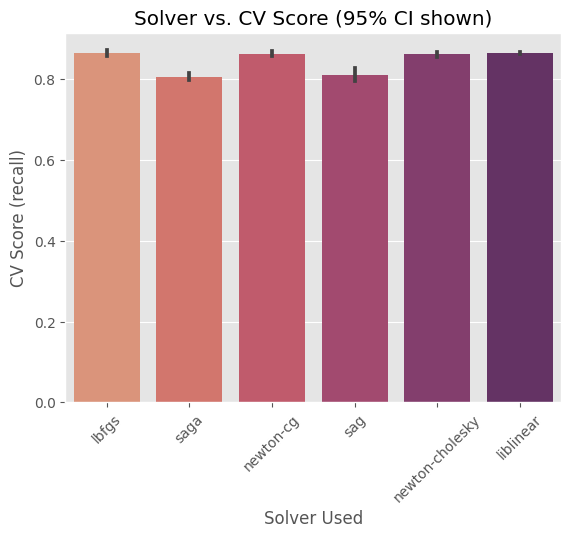

In [10]:
sns.barplot(data=grid_cv_results_logreg, x='param_logisticregression__solver', y='mean_test_score', palette='flare')
plt.ylabel('CV Score (recall)')
plt.xlabel('Solver Used')
plt.title('Solver vs. CV Score (95% CI shown)')
plt.xticks(rotation=45)
plt.show()

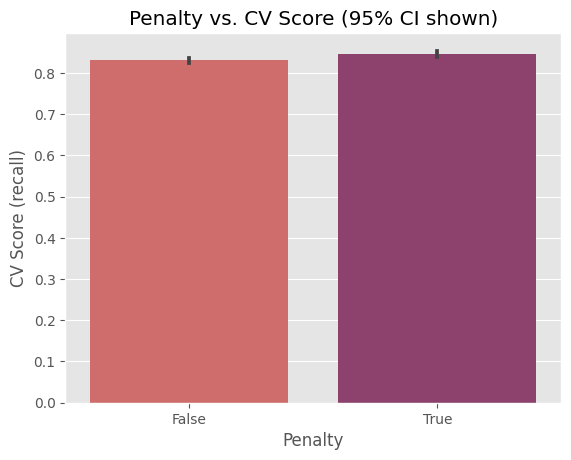

In [11]:
sns.barplot(data=grid_cv_results_logreg, x='param_logisticregression__fit_intercept', y='mean_test_score', palette='flare')
plt.ylabel('CV Score (recall)')
plt.xlabel('Penalty')
plt.title('Penalty vs. CV Score (95% CI shown)')
plt.show()

In [12]:
final_logreg = grid_cv_logreg.best_estimator_
final_logreg.fit(X_train, y_train)
y_hat_logreg = final_logreg.predict(X_test)
recall_logreg = recall_score(y_test, y_hat_logreg)

print(f'Logistic Regression Train CV Score (recall): {grid_cv_logreg.best_score_:.3f}')
print(f'Logistic Regression Test Recall: {recall_logreg:.3f}')

Logistic Regression Train CV Score (recall): 0.886
Logistic Regression Test Recall: 0.926


In [13]:
final_logreg_performance = {'model': 'logistic_regression_classifier', 
                          'params': final_logreg.get_params(), 
                          'train_score_cv_recall': grid_cv_logreg.best_score_, 
                          'test_score_recall': recall_logreg}

field_names = final_logreg_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_logreg_performance)

## Linear Discriminant Analysis (LDA)

In [14]:
baseline_lda = LinearDiscriminantAnalysis()
baseline_lda_cv_scores = cross_val_score(baseline_lda, X_train_imputed, y_train, cv = 5, scoring = 'recall')
baseline_lda_cv_score_mean = baseline_lda_cv_scores.mean()
baseline_lda_cv_score_std = baseline_lda_cv_scores.std()

print(f'Baseline Linear Discriminant Analysis CV Score(Recall): {baseline_lda_cv_score_mean} +/- {baseline_lda_cv_score_std}')

Baseline Linear Discriminant Analysis CV Score(Recall): 0.8863649720834559 +/- 0.06292766662319323


In [15]:
# Get recall score for test data.  This will be the baseline 
baseline_lda.fit(X_train_imputed, y_train)
y_predict_baseline = baseline_lda.predict(X_test_imputed)
baseline_lda_test_recall = recall_score(y_test, y_predict_baseline)
print("Baseline LDA test recall:", baseline_lda_test_recall)

Baseline LDA test recall: 0.9148936170212766


In [16]:
lda_pipe = make_pipeline(SimpleImputer(missing_values=np.nan),
                            StandardScaler(),
                            LinearDiscriminantAnalysis())
params = [
    {'simpleimputer__strategy': ['mean', 'median'],
     'standardscaler': [None, StandardScaler()],
     'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen'],
     'lineardiscriminantanalysis__shrinkage': [None]},
    {'simpleimputer__strategy': ['mean', 'median'],
     'standardscaler': [None, StandardScaler()],
     'lineardiscriminantanalysis__solver': ['lsqr', 'eigen'],
     'lineardiscriminantanalysis__shrinkage': ['auto']}
    ]

grid_cv_lda = GridSearchCV(estimator=lda_pipe, param_grid=params, cv=5, 
                              scoring='recall', n_jobs=-1)
grid_cv_lda.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('lineardiscriminantanalysis',
                                        LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid=[{'lineardiscriminantanalysis__shrinkage': [None],
                          'lineardiscriminantanalysis__solver': ['svd', 'lsqr',
                                                                 'eigen'],
                          'simpleimputer__strategy': ['mean', 'median'],
                          'standardscaler': [None, StandardScaler()]},
                         {'lineardiscriminantanalysis__shrinkage': ['auto'],
                          'lineardiscriminantanalysis__solver': ['lsqr',
                                                                 'eigen'],
                          'simpleimputer__strategy': ['mean', 'median'],
                          'standardscaler': [None, StandardScaler()]}],
             scoring='recall')

In [17]:
grid_cv_results_lda=pd.DataFrame(grid_cv_lda.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_lda[['param_simpleimputer__strategy', 'param_standardscaler',
                     'param_lineardiscriminantanalysis__solver', 
                     'param_lineardiscriminantanalysis__shrinkage', 
                     'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,param_simpleimputer__strategy,param_standardscaler,param_lineardiscriminantanalysis__solver,param_lineardiscriminantanalysis__shrinkage,mean_test_score,std_test_score,rank_test_score
0,mean,None,svd,None,0.886365,0.062928,1
7,median,StandardScaler(),lsqr,None,0.886365,0.062928,1
11,median,StandardScaler(),eigen,None,0.886365,0.062928,1
1,mean,StandardScaler(),svd,None,0.886365,0.062928,1
9,mean,StandardScaler(),eigen,None,0.886365,0.062928,1


In [18]:
final_lda = grid_cv_lda.best_estimator_
final_lda.fit(X_train, y_train)
y_hat_lda = final_lda.predict(X_test)
recall_lda = recall_score(y_test, y_hat_lda)

print(f'LDA Train CV Score (recall): {grid_cv_lda.best_score_:.3f}')
print(f'LDA Test Recall: {recall_lda:.3f}')

LDA Train CV Score (recall): 0.886
LDA Test Recall: 0.915


In [19]:
final_lda_performance = {'model': 'linear_discriminant_analysis', 
                          'params': final_lda.get_params(), 
                          'train_score_cv_recall': grid_cv_lda.best_score_, 
                          'test_score_recall': recall_lda}

field_names = final_lda_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_lda_performance)

## Quadratic Discriminant Analysis (QDA)

In [20]:
baseline_qda = QuadraticDiscriminantAnalysis()
baseline_qda_cv_scores = cross_val_score(baseline_qda, X_train_imputed, y_train, cv = 5, scoring = 'recall')
baseline_qda_cv_score_mean = baseline_qda_cv_scores.mean()
baseline_qda_cv_score_std = baseline_qda_cv_scores.std()

print(f'Baseline Quadratic Discriminant Analysis CV Score(Recall): {baseline_qda_cv_score_mean} +/- {baseline_qda_cv_score_std}')

Baseline Quadratic Discriminant Analysis CV Score(Recall): 0.8548927416985013 +/- 0.05358228200061325


In [21]:
# Get recall score for test data.  This will be the baseline 
baseline_qda.fit(X_train_imputed, y_train)
y_predict_baseline = baseline_qda.predict(X_test_imputed)
baseline_qda_test_recall = recall_score(y_test, y_predict_baseline)
print("Baseline QDA test recall:", baseline_qda_test_recall)

Baseline QDA test recall: 0.8723404255319149


In [22]:
qda_pipe = make_pipeline(SimpleImputer(missing_values=np.nan),
                            StandardScaler(),
                            QuadraticDiscriminantAnalysis())
params = {'simpleimputer__strategy': ['mean', 'median'],
            'standardscaler': [None, StandardScaler()],
            'quadraticdiscriminantanalysis__reg_param': np.linspace(0, 0.5, 6)}

grid_cv_qda = GridSearchCV(estimator=qda_pipe, param_grid=params, cv=5, 
                              scoring='recall', n_jobs=-1)
grid_cv_qda.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('quadraticdiscriminantanalysis',
                                        QuadraticDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'quadraticdiscriminantanalysis__reg_param': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None, StandardScaler()]},
             scoring='recall')

In [23]:
grid_cv_results_qda=pd.DataFrame(grid_cv_qda.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_qda[['param_simpleimputer__strategy', 'param_standardscaler',
                     'param_quadraticdiscriminantanalysis__reg_param', 
                     'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,param_simpleimputer__strategy,param_standardscaler,param_quadraticdiscriminantanalysis__reg_param,mean_test_score,std_test_score,rank_test_score
6,median,None,0.1,0.891184,0.044831,1
4,mean,None,0.1,0.888775,0.048182,2
10,median,None,0.2,0.876638,0.049968,3
8,mean,None,0.2,0.876638,0.049968,3
19,median,StandardScaler(),0.4,0.866941,0.034558,5


In [24]:
final_qda = grid_cv_qda.best_estimator_
final_qda.fit(X_train, y_train)
y_hat_qda = final_qda.predict(X_test)
recall_qda = recall_score(y_test, y_hat_qda)

print(f'QDA Train CV Score (recall): {grid_cv_qda.best_score_:.3f}')
print(f'QDA Test Recall: {recall_qda:.3f}')

QDA Train CV Score (recall): 0.891
QDA Test Recall: 0.936


In [25]:
final_qda_performance = {'model': 'quadratic_discriminant_analysis', 
                          'params': final_qda.get_params(), 
                          'train_score_cv_recall': grid_cv_qda.best_score_, 
                          'test_score_recall': recall_qda}

field_names = final_qda_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_qda_performance)

## Naive Bayes